## ENHANCING STORE SALES PREDICTION FOR FAVORITA.

## 1. BUSINESS UNDERSTANDING
Corporation Favorita is a significant actor in Ecuador's dynamic economic environment and contributes to the country's economic diversification as a result of the country's strong reliance on oil prices. Favorita, a complex Ecuadorian business, operates both inside and outside of national borders and makes investments in a range of industries to support economic resilience.

Corporation Favorita is aware of the crucial necessity for well-informed decision-making in its pursuit of sustainable growth and economic stability. In order to achieve this, the company aims to maximize the potential of data-driven insights, particularly with regard to its grocery retail operations. Favorita intends to bolster its market presence, optimize its offers, and contribute to the resiliency of the country's economy by diving into the complex patterns of retail sales, product dynamics, and transaction behaviors.


### Problem Statement
The inconsistent and unpredictable nature of sales across various stores and product categories is the issue that we seek to solve. Our capacity to make data-driven decisions in inventory management and personnel is hampered by the variability of the sales data. We want to estimate in-store sales precisely by creating an accurate regression model, which will enhance inventory management, lessen stockouts and overstocking, and eventually increase income potential. When this predictive model is successfully implemented, store operations, customer satisfaction, and overall business performance will all be improved.

## Objectives of the Project.
1.  Investigate the performance variations across different Favorita stores.
2. Create reliable time series forecasting models that can accurately anticipate unit sales for the wide range of products sold in different Favorita stores.
3. Assess the impact of promotional strategies on sales. By analyzing the correlation between promotions and sales spikes, the project aims to determine the efficacy of different promotional tactics and optimize their deployment.
4. Conduct a comprehensive analysis of annual transaction volumes, trends, and variations.

## 2. DATA COLLECTION AND DATA PREPARATION

    2.1 DATA COLLECTION

Installations and Importing the necessary libraries

In [307]:
#Install pyodbc and python-dotenv
%pip install pyodbc  
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [308]:
#Importing the necessary Libraries.
#Libraries to collect and manipulate data-cleaning
import pyodbc                    #
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import os,pickle
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
import missingno as msno
import zipfile
import warnings 
warnings.filterwarnings('ignore')

#Libraries for Vizualization and EDA
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates

# EDA (pandas-profiling, etc. )
import ydata_profiling as pp

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

### Data Loading
Here we are going to load all our datasets from dapDB and  read the other data files provided. We will passing in the parse dates and reindex the dates column to easen our analysis

I. datasets from DB

These are oil, stores and holiday/event datasets

In [309]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")


connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [310]:
# Use the connect method of the pyodbc library and pass in the connection string.
connection=pyodbc.connect(connection_string)

In [311]:
#Getting the 3 datasets and creating a dataframe names for the 3.
query="Select * from dbo.oil"
data_oil=pd.read_sql(query,connection,index_col = 'date',parse_dates =True)
query="Select * from dbo.holidays_events"
data_events=pd.read_sql(query,connection,index_col ='date',parse_dates =True)
query="Select * from dbo.stores"
data_stores=pd.read_sql(query,connection)

II. Loading the csv files datasets. 

These are the test, Sample Submission in CSV form and the train an transactions stored in a zipfile


In [312]:
# using pandas to load datasets stored as CSV
data_submission = pd.read_csv('sample_submission.csv')
data_test = pd.read_csv('test.csv',index_col = 'date',parse_dates =True)


In [313]:
# Specify the ZIP file path
zip_file_path = 'store-sales-forecasting.zip'

# Initialize the ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

    # Read the 'train.csv' file from the ZIP archive
    with zip_ref.open('train.csv') as train:
        data_train = pd.read_csv(train,index_col = 'date',parse_dates =True)

    # Read the 'transactions.csv' file from the ZIP archive
    with zip_ref.open('transactions.csv') as transactions:
        data_transaction = pd.read_csv(transactions,index_col = 'date',parse_dates =True)

##### 2.2 DATA PREPARATION AND PROCESSING

In this we are going to prepare our data by exploring, cleaning and preparing for analysis and modeling
The datasets are stored in these dataframes: 
- Main datasets for project: **data_train and data_test**
- Supplementary datasets: **data_transaction, data_oil, data_events, data_stores and data_submission**

##### 2.2.1. Previewing the datasets and formulate hypothesis and questions to be used for analysis

- *train dataset previewing*

In [314]:
#check features of the train dataset
data_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [315]:
#shape of the df-train
data_train.shape

(3000888, 5)

In [316]:
#check data infor
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


The train dataset has 6 columns - **with date column reindex**,  one categorical and 4 numerical and 300088 rows/entries

In [317]:
#check the columns
data_train.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

- *previewing Test dataset*

In [318]:
##check features of the test dataset
data_test.head()

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [319]:
#shape on test data
data_test.shape

(28512, 4)

In [320]:
#check data infor
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2017-08-16 to 2017-08-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   store_nbr    28512 non-null  int64 
 2   family       28512 non-null  object
 3   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [321]:
data_test.columns

Index(['id', 'store_nbr', 'family', 'onpromotion'], dtype='object')

From the info data, test dataset has 5 columns - **with date column reindexed**, 1 categorical and 3 numerical - **missing the sales column** and  28512 rows/entries

- *transactions dataset previewing*

In [322]:
#check features of the transaction dataset
data_transaction.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


In [323]:
#shape on transaction data
data_transaction.shape

(83488, 2)

In [324]:
#check data infor
data_transaction.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83488 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     83488 non-null  int64
 1   transactions  83488 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


In [325]:
#rechecking columns
data_transaction.columns

Index(['store_nbr', 'transactions'], dtype='object')

The Transaction dataset has  3 columns - **with date column reindex** and 2 numerical columns and 83488 rows/entries

- *Previewing the Store dataset*

In [326]:
#check features of the store dataset
data_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [327]:
#shape on store data
data_stores.shape

(54, 5)

In [328]:
#check data infor
data_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [329]:
#rechecking columns
data_stores.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

The stores dataset have: 5 columns(3 categorical and 2 numerical) and 54 rows/entries. showing locations and store numbers and the how many clusters each store has.

- *Previewing the holiday/events dataset*

In [330]:
#check features of the event dataset
data_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [331]:
#shape on event data
data_events.shape

(350, 5)

In [332]:
#check data infor
data_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 2012-03-02 to 2017-12-26
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         350 non-null    object
 1   locale       350 non-null    object
 2   locale_name  350 non-null    object
 3   description  350 non-null    object
 4   transferred  350 non-null    bool  
dtypes: bool(1), object(4)
memory usage: 14.0+ KB


In [333]:
#rechecking columns
data_events.columns

Index(['type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

The Holiday/event dataset has  6 columns - **with date column reindex** ,3 categorical and one boolen and 350 rows/entries

- *Previewing the Oil dataset*

In [334]:
#check features of the oil dataset
data_oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997


In [335]:
#shape on oil data
data_oil.shape

(1218, 1)

In [336]:
#check data infor
data_oil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0+ KB


In [337]:
#rechecking columns
data_oil.columns

Index(['dcoilwtico'], dtype='object')

The Oil dataset has  2 columns - **with date column reindex** and 1 numerical columns and 1218 rows/entries

## <u>Hypothesis Formula</u>
Null Hypothesis(HO): There is no significant relationship between stores and transaction in  Ecuadorian-based grocery retailer.

Alternative Hypothesis(H1): There is a significant relationship between stores and transactions in  Ecuadorian-based grocery retailer.

<u>**Required Questions**</u>
1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

3. Are certain groups of stores selling more products? (Cluster, city, state, type)

4. Are sales affected by promotions, oil prices and holidays?

5. What analysis can we get from the date and its extractable features?

6. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

<u>**Other Questions**</u>
1. How Does Promotional Activity Impact Sales Performance?

2. Is There a Correlation Between Oil Prices and Store Sales?

3. How Do Holidays and Special Events Affect Sales Patterns?

4. Can Store Clusters, Types, and Locations Predict Sales Variation?

5. How Have Total Sales Evolved Over the Years?

### 2.2.2 <u>Data Cleaning </u>

Here we going to check for null values, impute null values and check for duplicates on each datasets in preparation for EDA analysis

- Cleaning Train Data

In [338]:
#check the dataframe
data_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [339]:
#Checking duplicated data
data_train.duplicated().sum()

0

we have no duplicates lets check the null values

In [340]:
#checking null values
data_train.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

<Axes: >

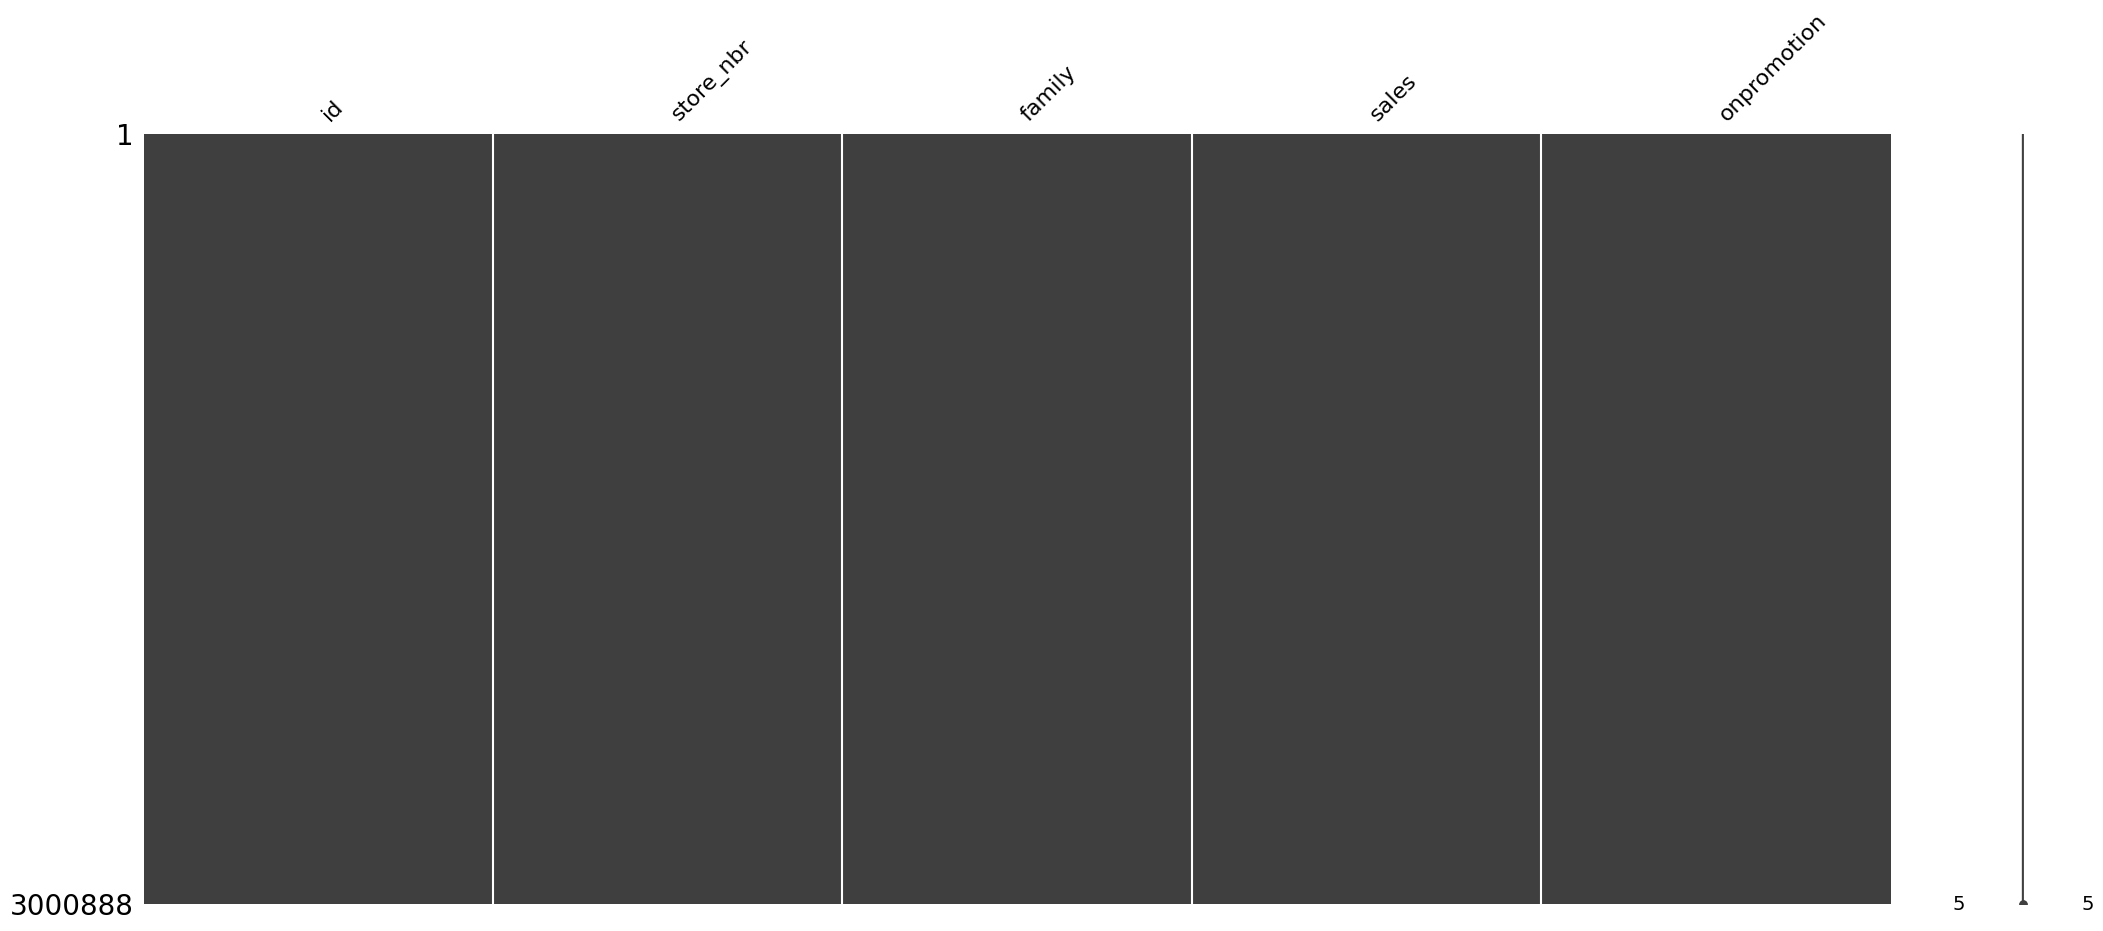

In [341]:
#visualizing missing data in a dataset. using msno.matrix
msno.matrix(data_train)

There are no missing values, lets check the datatypes for the columns and statistical description of the data

In [342]:
data_train.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,3000888.0,NaN,NaN,NaN,1500443.5,866281.891642,0.0,750221.75,1500443.5,2250665.25,3000887.0
store_nbr,3000888.0,NaN,NaN,NaN,27.5,15.585787,1.0,14.0,27.5,41.0,54.0
family,3000888,33,AUTOMOTIVE,90936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,3000888.0,NaN,NaN,NaN,357.775749,1101.997721,0.0,0.0,11.0,195.84725,124717.0
onpromotion,3000888.0,NaN,NaN,NaN,2.60277,12.218882,0.0,0.0,0.0,0.0,741.0


From the Statistical description: The most frequent family is Automotive occuring in 90936 times while the other varibales(ID, storenumber,sales and on promotion have 0 as entry as most frequent, NaN) 

In [343]:
data_train.dtypes

id               int64
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [344]:
#lets convert all numeric columns to numeric using pandas and recheck missing values
data_train['sales'] = pd.to_numeric(data_train['sales'], errors='coerce')
data_train['store_nbr'] = pd.to_numeric(data_train['store_nbr'], errors='coerce')
data_train['onpromotion'] = pd.to_numeric(data_train['onpromotion'], errors='coerce')

In [345]:
data_train.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

No null values even after converting all numeric columns to pandas numeric. 
Lets now create new features - year, month and day name for the date column.

In [346]:
#By use pandas lets create a time series
data_train['Year'] = data_train.index.year
data_train['Month'] = data_train.index.month
data_train['WeekDay Name'] = data_train.index.day_name()

#Show the dataframe part of dataframe using .head()
data_train.head()

,id,store_nbr,family,sales,onpromotion,Year,Month,WeekDay Name
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,2013,1,Tuesday


In [347]:
#Lets now rearrange and rename the rows.
# Rename the columns
data_train = data_train.rename(columns={
    'id': 'ID',
    'store_nbr': 'Store_nbr',
    'family': 'Family',
    'sales': 'Sales($)',
    'onpromotion': 'Onpromotion',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name'
})

In [348]:
#rearrange 
# Define the new column order
new_column_order = ['ID', 'Store_nbr', 'Family', 'Onpromotion', 'Year', 'Month', 'Weekday Name', 'Sales($)']

# Rename and rearrange the columns
final_train = data_train[new_column_order]

# Show the DataFrame with the renamed and rearranged columns using .head()
final_train.head()

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name,Sales($)
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0,2013,1,Tuesday,0.0
2013-01-01,1,1,BABY CARE,0,2013,1,Tuesday,0.0
2013-01-01,2,1,BEAUTY,0,2013,1,Tuesday,0.0
2013-01-01,3,1,BEVERAGES,0,2013,1,Tuesday,0.0
2013-01-01,4,1,BOOKS,0,2013,1,Tuesday,0.0


The final cleaned Train Data

In [349]:
#the final dataframe: 
final_train.head()

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name,Sales($)
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0,2013,1,Tuesday,0.0
2013-01-01,1,1,BABY CARE,0,2013,1,Tuesday,0.0
2013-01-01,2,1,BEAUTY,0,2013,1,Tuesday,0.0
2013-01-01,3,1,BEVERAGES,0,2013,1,Tuesday,0.0
2013-01-01,4,1,BOOKS,0,2013,1,Tuesday,0.0


- Cleaning the Test Data

In [350]:
#check the dataframe
data_test.head()

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [351]:
#Checking duplicated data
data_test.duplicated().sum()

0

We have no duplicates in the test datasets

In [352]:
#checking null values
data_test.isnull().sum()

id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64

<Axes: >

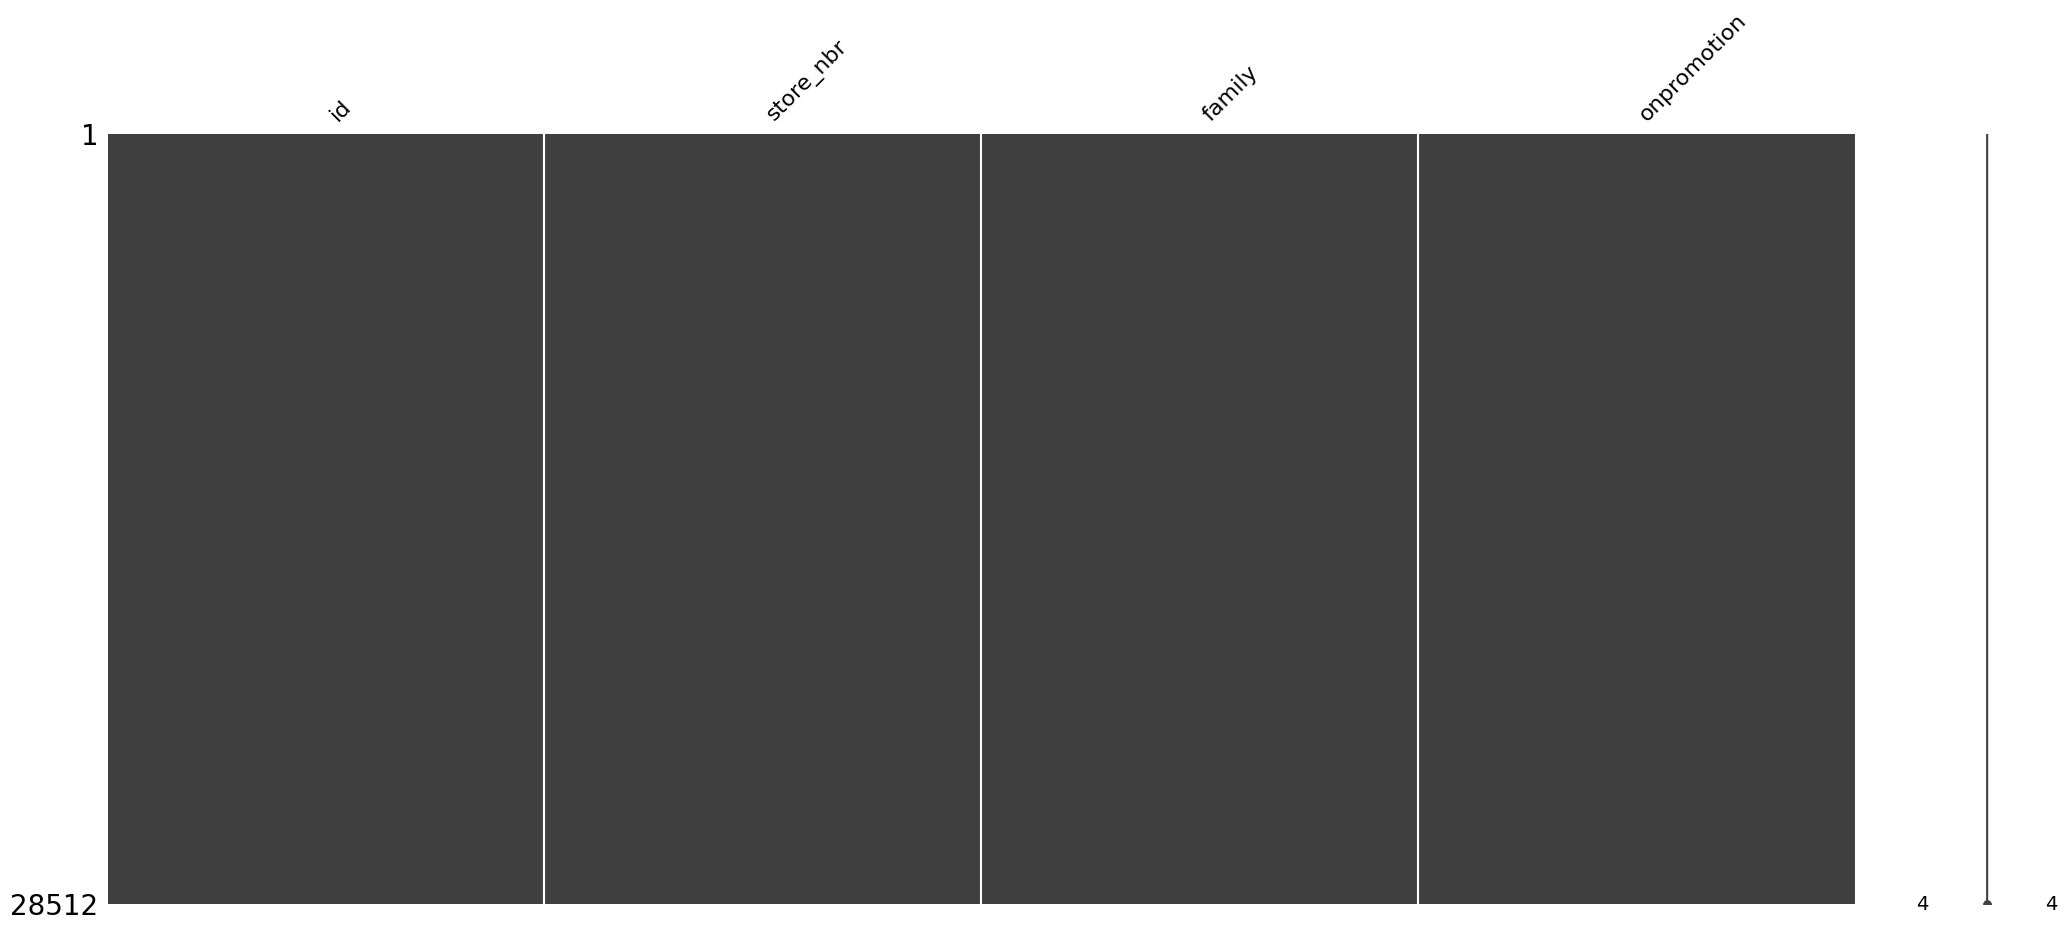

In [353]:
#visualizing missing data in a dataset. using msno.matrix
msno.matrix(data_test)

There are no missing values, lets check the  statistical description of the data

In [354]:
data_test.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,28512.0,NaN,NaN,NaN,3015143.5,8230.849774,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0
store_nbr,28512.0,NaN,NaN,NaN,27.5,15.586057,1.0,14.0,27.5,41.0,54.0
family,28512,33,AUTOMOTIVE,864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
onpromotion,28512.0,NaN,NaN,NaN,6.965383,20.683952,0.0,0.0,0.0,6.0,646.0


From the Statistical description: The most frequent family is Automotive occuring in 864 times while the other varibales(ID, storenumber,and on promotion have 0 as the entry as the most frequent, NaN)

In [355]:
data_test.dtypes

id              int64
store_nbr       int64
family         object
onpromotion     int64
dtype: object

In [356]:
#lets convert all numeric columns to numeric using pandas and recheck missing values
data_test['store_nbr'] = pd.to_numeric(data_test['store_nbr'], errors='coerce')
data_test['onpromotion'] = pd.to_numeric(data_test['onpromotion'], errors='coerce')

In [357]:
data_test.isnull().sum()

id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64

No null values even after converting all numeric columns to pandas numeric. 
Lets now create new features - year, month and day name for the date column.

In [358]:
#By use pandas lets create a time series
data_test['Year'] = data_test.index.year
data_test['Month'] = data_test.index.month
data_test['WeekDay Name'] = data_test.index.day_name()

#Show the dataframe part of dataframe using .head()
data_test.head()

,id,store_nbr,family,onpromotion,Year,Month,WeekDay Name
date,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,2017,8,Wednesday
2017-08-16,3000889,1,BABY CARE,0,2017,8,Wednesday
2017-08-16,3000890,1,BEAUTY,2,2017,8,Wednesday
2017-08-16,3000891,1,BEVERAGES,20,2017,8,Wednesday
2017-08-16,3000892,1,BOOKS,0,2017,8,Wednesday


In [359]:
#Lets now rearrange and rename the rows.
# Rename the columns
data_test = data_test.rename(columns={
    'id': 'ID',
    'store_nbr': 'Store_nbr',
    'family': 'Family',
    'onpromotion': 'Onpromotion',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name'
})

In [360]:
#rearrange 
# Define the new column order
new_col_order = ['ID', 'Store_nbr', 'Family', 'Onpromotion', 'Year', 'Month', 'Weekday Name']

# Rename and rearrange the columns
final_test = data_test[new_col_order]

# Show the DataFrame with the renamed and rearranged columns using .head()
final_test.head()

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name
date,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,2017,8,Wednesday
2017-08-16,3000889,1,BABY CARE,0,2017,8,Wednesday
2017-08-16,3000890,1,BEAUTY,2,2017,8,Wednesday
2017-08-16,3000891,1,BEVERAGES,20,2017,8,Wednesday
2017-08-16,3000892,1,BOOKS,0,2017,8,Wednesday


The final cleaned Test data

In [361]:
final_test.head(10)

,ID,Store_nbr,Family,Onpromotion,Year,Month,Weekday Name
date,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,2017,8,Wednesday
2017-08-16,3000889,1,BABY CARE,0,2017,8,Wednesday
2017-08-16,3000890,1,BEAUTY,2,2017,8,Wednesday
2017-08-16,3000891,1,BEVERAGES,20,2017,8,Wednesday
2017-08-16,3000892,1,BOOKS,0,2017,8,Wednesday
2017-08-16,3000893,1,BREAD/BAKERY,12,2017,8,Wednesday
2017-08-16,3000894,1,CELEBRATION,0,2017,8,Wednesday
2017-08-16,3000895,1,CLEANING,25,2017,8,Wednesday
2017-08-16,3000896,1,DAIRY,45,2017,8,Wednesday


- Cleaning the transactions dataset

In [362]:
#check the dataframe
data_transaction.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


In [363]:
# Find and display duplicated rows in the DataFrame
duplicated_rows = data_transaction[data_transaction.duplicated()]
print(duplicated_rows)

            store_nbr  transactions
date                               
2013-01-04         26           813
2013-01-04         30           689
2013-01-08         13           879
2013-01-09         51          1786
2013-01-10         19           960
...               ...           ...
2017-08-15         48          2722
2017-08-15         51          1573
2017-08-15         52          2255
2017-08-15         53           932
2017-08-15         54           802

[45955 rows x 2 columns]


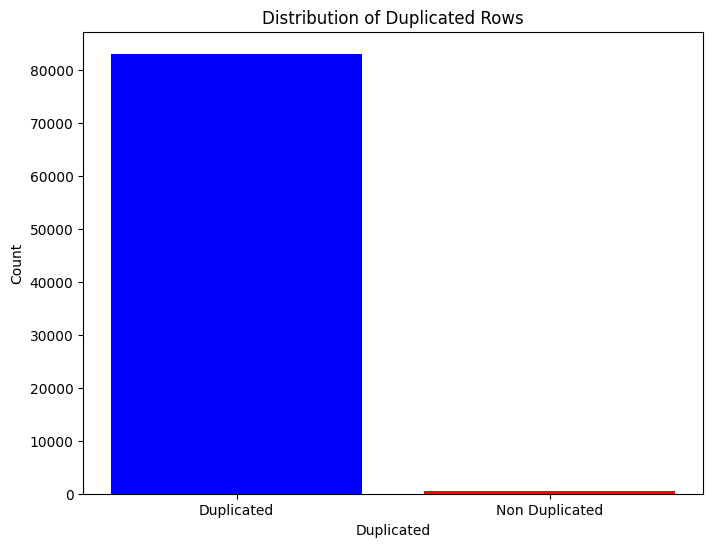

In [407]:
#Find and count duplicated rows
duplicated_counts = data_transaction.duplicated().value_counts()

# Plot the distribution of duplicated rows
plt.figure(figsize=(8, 6))
plt.bar(['Duplicated', 'Non Duplicated'], duplicated_counts, color=['blue', 'red'])
plt.title('Distribution of Duplicated Rows')
plt.xlabel('Duplicated')
plt.ylabel('Count')
plt.show()

We have 45955 duplicated data, however  In transactional data, duplicated rows may not necessarily indicate an issue that needs to be resolved by deleting the duplicates. Duplicated rows in transactional data can often be expected and legitimate, especially when transactions can occur multiple times for the same entity or under certain conditions.

In [365]:
#checking null values
data_train.isnull().sum()

ID              0
Store_nbr       0
Family          0
Sales($)        0
Onpromotion     0
Year            0
Month           0
Weekday Name    0
dtype: int64

<Axes: >

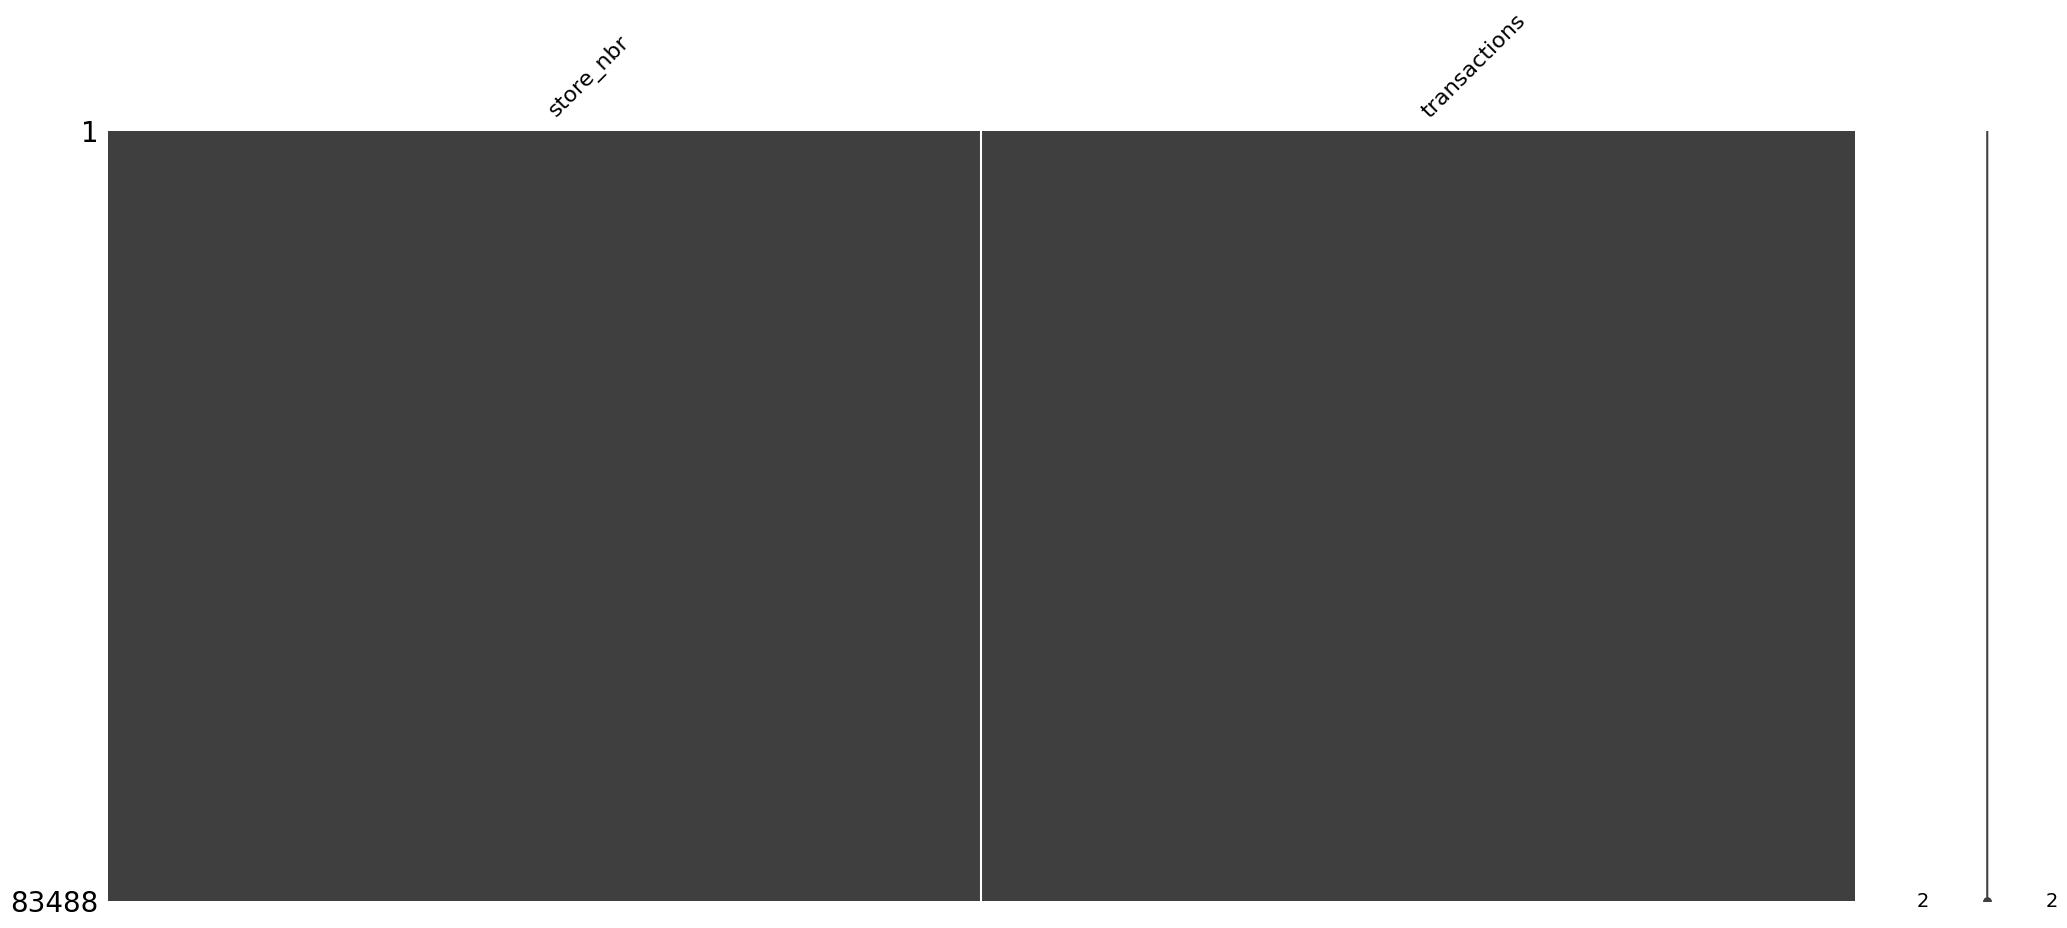

In [366]:
msno.matrix(data_transaction)

There are no null values. Lets check the statistical distribution

In [367]:
#checking statistical distribution
data_transaction.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
store_nbr,83488.0,26.939237,15.608204,1.0,13.0,27.0,40.0,54.0
transactions,83488.0,1694.602158,963.286644,5.0,1046.0,1393.0,2079.0,8359.0


In [368]:
#checking for dtypes
data_transaction.dtypes

store_nbr       int64
transactions    int64
dtype: object

In [369]:
#lets convert all numeric columns to numeric using pandas and recheck missing values
data_transaction['store_nbr'] = pd.to_numeric(data_transaction['store_nbr'], errors='coerce')
data_transaction['transactions'] = pd.to_numeric(data_transaction['transactions'], errors='coerce')

In [370]:
#Rechecking for missing values
data_transaction.isnull().sum()

store_nbr       0
transactions    0
dtype: int64

There are no missing values. Lets create new features from the data column i.e Year,Month and Weekday Name

In [371]:
#By use pandas lets create a time series
data_transaction['Year'] = data_transaction.index.year
data_transaction['Month'] = data_transaction.index.month
data_transaction['WeekDay Name'] = data_transaction.index.day_name()

#Show the dataframe part of dataframe using .head()
data_transaction.head()

,store_nbr,transactions,Year,Month,WeekDay Name
date,,,,,
2013-01-01,25,770,2013,1,Tuesday
2013-01-02,1,2111,2013,1,Wednesday
2013-01-02,2,2358,2013,1,Wednesday
2013-01-02,3,3487,2013,1,Wednesday
2013-01-02,4,1922,2013,1,Wednesday


In [372]:
# Rename the columns
data_transaction = data_transaction.rename(columns={
    'store_nbr': 'Store_nbr',
    'transactions': 'Transaction',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name'
})

The final Cleaned Transaction Dataset

In [373]:
data_transaction.head()

,Store_nbr,Transaction,Year,Month,Weekday Name
date,,,,,
2013-01-01,25,770,2013,1,Tuesday
2013-01-02,1,2111,2013,1,Wednesday
2013-01-02,2,2358,2013,1,Wednesday
2013-01-02,3,3487,2013,1,Wednesday
2013-01-02,4,1922,2013,1,Wednesday


- Cleaning Store DataSet

In [374]:
#check the dataframe
data_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [375]:
#Checking duplicated data
data_stores.duplicated().sum()

0

There are no duplicated rows lets check the null values

In [376]:
#checking null values
data_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

<Axes: >

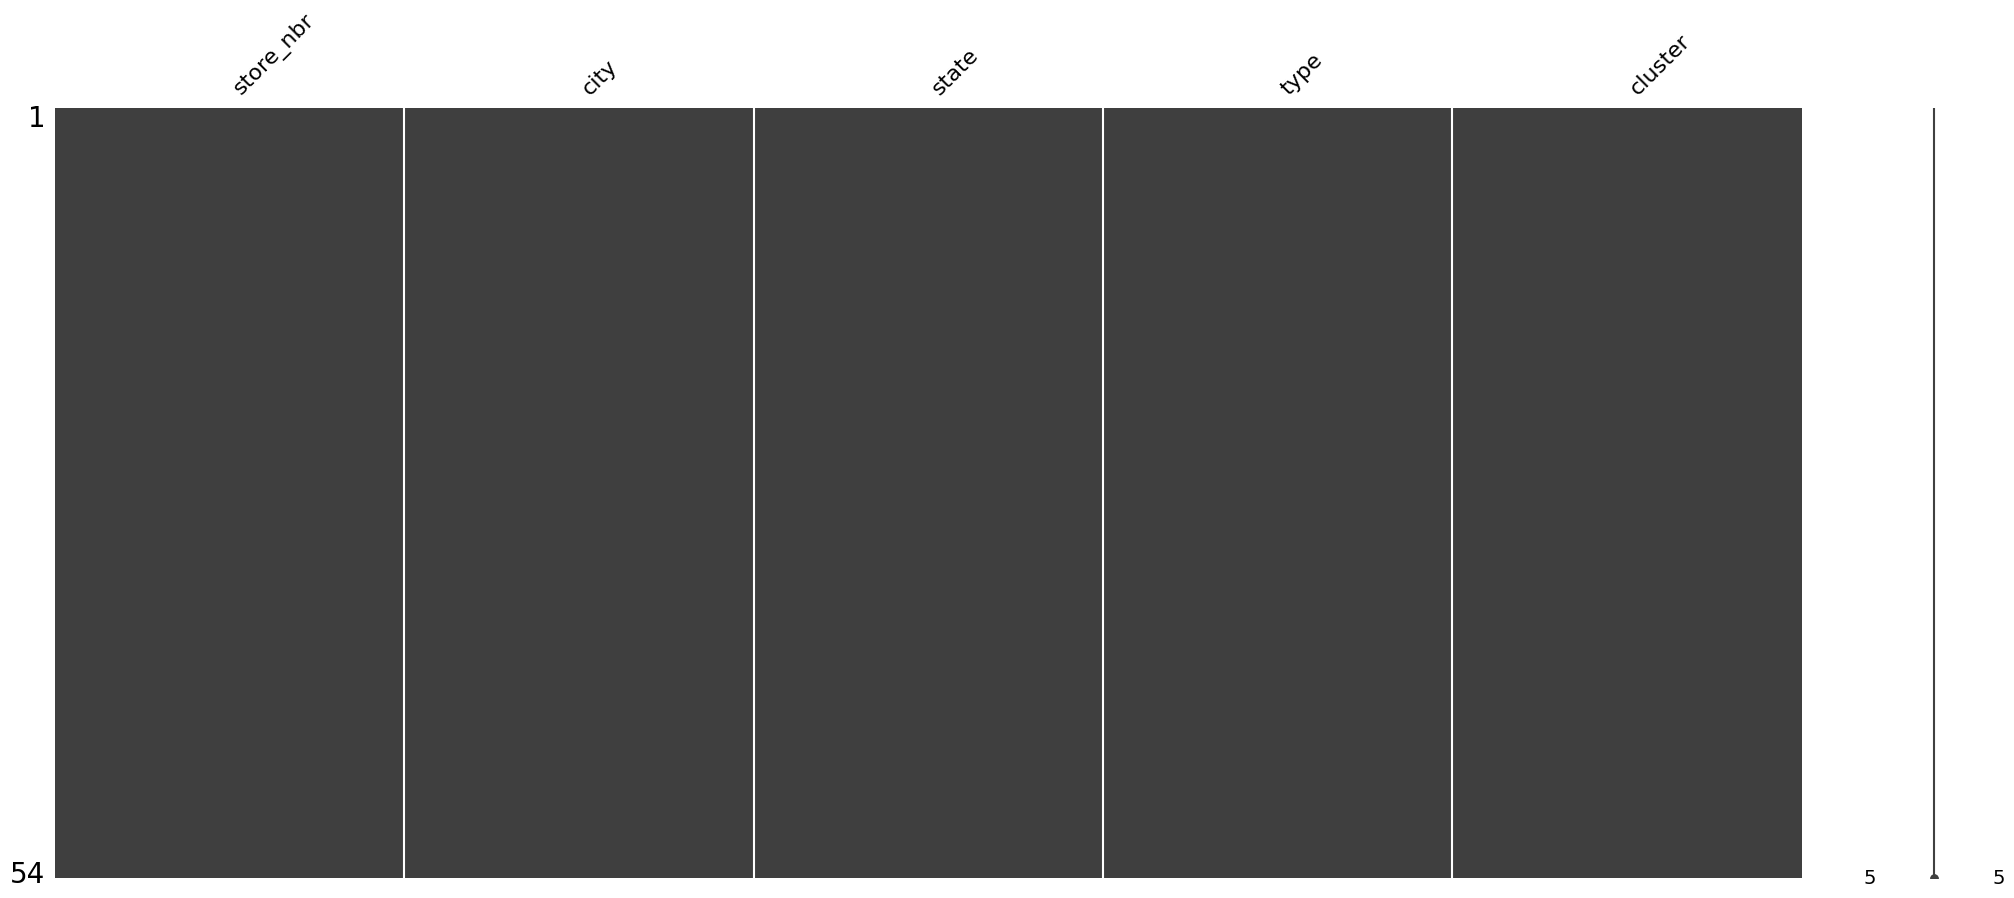

In [377]:
msno.matrix(data_stores)

There are no missing values, lets check statatical distribution

In [378]:
#checking statistical distribution
data_stores.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
store_nbr,54.0,NaN,NaN,NaN,27.5,15.732133,1.0,14.25,27.5,40.75,54.0
city,54,22,Quito,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,54,16,Pichincha,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,54,5,D,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster,54.0,NaN,NaN,NaN,8.481481,4.693395,1.0,4.0,8.5,13.0,17.0


From Stastical distribution: The state Pichincha and Quito city are most frequent store locations. We will see the distribution in the EDA analysis step.

In [379]:
#checking for dtypes
data_stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

In [380]:
#lets convert all numeric columns to numeric using pandas 
# then recheck missing values
data_stores['store_nbr'] = pd.to_numeric(data_stores['store_nbr'], errors='coerce')
data_stores['cluster'] = pd.to_numeric(data_stores['cluster'], errors='coerce')

In [381]:
#Rechecking for missing values
data_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

There are no missing values. Lets rename the columns to start with capital letter

In [382]:
# Rename the columns
data_stores = data_stores.rename(columns={
    'store_nbr': 'Store_nbr',
    'city': 'City',
    'state': 'State',
    'type': 'Type',
    'cluster': 'Cluster'
})

The final cleaned store data

In [383]:
data_stores.head()

,Store_nbr,City,State,Type,Cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


- Cleaning Oil data

In [384]:
#check the dataframe
data_oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997


In [385]:
#Checking duplicated data
# Find and display duplicated rows in the DataFrame
duplicated_rows = data_oil[data_oil.duplicated()]
print(duplicated_rows)

            dcoilwtico
date                  
2013-01-21         NaN
2013-02-15   95.949997
2013-02-18         NaN
2013-02-22   93.120003
2013-03-19   92.440002
...                ...
2017-08-23   48.450001
2017-08-24   47.240002
2017-08-25   47.650002
2017-08-28   46.400002
2017-08-29   46.459999

[219 rows x 1 columns]


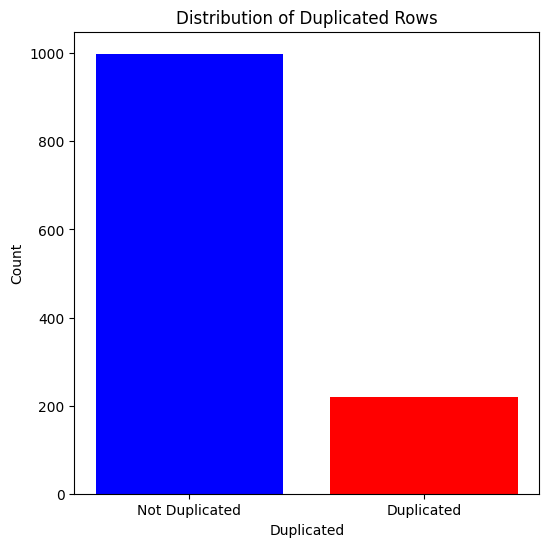

In [386]:
# Find and count duplicated rows
duplicated_count = data_oil.duplicated().value_counts()

# Create a count plot to visualize the distribution of duplicated rows
plt.figure(figsize=(6, 6))
plt.bar(['Not Duplicated', 'Duplicated'], duplicated_count, color=['blue', 'red'])
plt.title('Distribution of Duplicated Rows')
plt.xlabel('Duplicated')
plt.ylabel('Count')
plt.show()


We have 219 rows duplicated, it suggests that the same daily price rate occurred on multiple days. In this scenario, there is typically no need to remove duplicates, as these duplicated rows represent valid and meaningful data.

In [387]:
#checking null values
data_oil.isnull().sum()

dcoilwtico    43
dtype: int64

<Axes: >

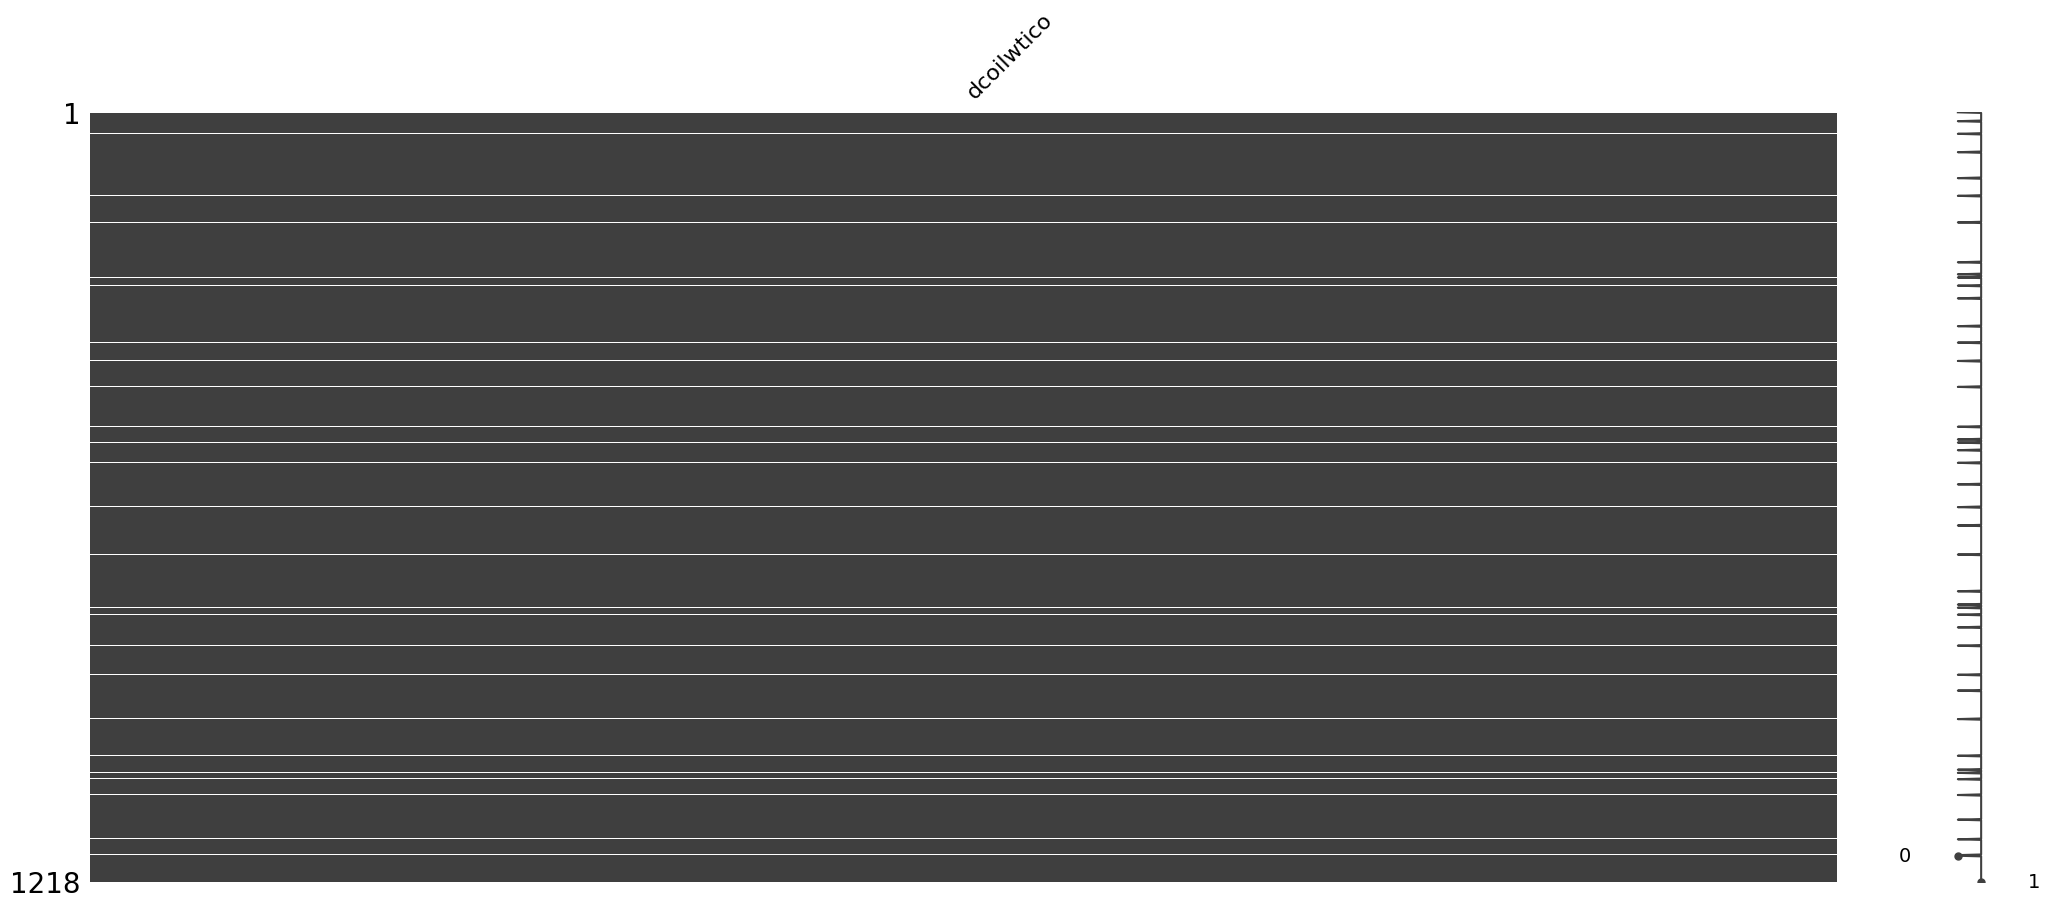

In [388]:
msno.matrix(data_oil)

We have 43 missing values in the oil dataset. Lets fill the values using interpolation

In [389]:
# Interpolate missing values using the default linear method
data_oil['dcoilwtico'].interpolate(method='linear', inplace=True)
# Check if there are any remaining missing values
missing_values = data_oil['dcoilwtico'].isnull().sum()

if missing_values == 0:
    print("All missing values have been filled.")
else:
    print(f"There are still {missing_values} missing values.")

There are still 1 missing values.


Lets fill the missing value with bfill method.

In [390]:
# imputing NaN values form the dataset
data_oil = data_oil.fillna(method='bfill')

In [391]:
#rechecking missing values
data_oil.isnull().sum()

dcoilwtico    0
dtype: int64

The missing values has been handled, lets now see the statistical distribution

In [392]:
#checking statistical distribution
data_oil.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
dcoilwtico,1218.0,67.682742,25.632933,26.190001,46.4225,53.184999,95.684999,110.620003


In [393]:
#checking datatypes 
data_oil.dtypes

dcoilwtico    float64
dtype: object

In [394]:
#lets convert all numeric columns to numeric using pandas 
# then recheck missing values
data_oil['dcoilwtico'] = pd.to_numeric(data_oil['dcoilwtico'], errors='coerce')

In [395]:
#rechecking missing values
data_oil.isnull().sum()

dcoilwtico    0
dtype: int64

There are no missing values even after changing the numerical columns to numeric. Lets create new features from the data column i.e Year,Month and Weekday Name

In [398]:
# the index is a datetime index
data_oil.index = pd.to_datetime(data_oil.index)

# Create columns for year, month, and weekday name
data_oil['Year'] = data_oil.index.year
data_oil['Month'] = data_oil.index.month
data_oil['WeekDay Name'] = data_oil.index.day_name()

# Show the DataFrame using .head()
data_oil.head()

,dcoilwtico,Year,Month,WeekDay Name
date,,,,
2013-01-01,93.139999,2013,1,Tuesday
2013-01-02,93.139999,2013,1,Wednesday
2013-01-03,92.970001,2013,1,Thursday
2013-01-04,93.120003,2013,1,Friday
2013-01-07,93.199997,2013,1,Monday


In [399]:
# Rename the columns
data_oil = data_oil.rename(columns={
    'dcoilwtico': 'Daily Oil Price',
    'Year': 'Year',
    'Month': 'Month',
    'WeekDay Name': 'Weekday Name',
})

The final cleaned oil data


In [400]:
data_oil.head()

,Daily Oil Price,Year,Month,Weekday Name
date,,,,
2013-01-01,93.139999,2013,1,Tuesday
2013-01-02,93.139999,2013,1,Wednesday
2013-01-03,92.970001,2013,1,Thursday
2013-01-04,93.120003,2013,1,Friday
2013-01-07,93.199997,2013,1,Monday


- Cleaning Events/Holiday Data

In [401]:
#check the dataframe
data_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [403]:
#Checking duplicated data
# Find and display duplicated rows in the DataFrame
dupli_rows = data_events[data_events.duplicated()]
print(dupli_rows)

                  type    locale locale_name                    description   
date                                                                          
2013-02-12     Holiday  National     Ecuador                       Carnaval  \
2013-03-02     Holiday     Local       Manta             Fundacion de Manta   
2013-04-01     Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2013-04-12     Holiday     Local      Cuenca            Fundacion de Cuenca   
2013-04-14     Holiday     Local    Libertad      Cantonizacion de Libertad   
...                ...       ...         ...                            ...   
2017-12-22  Additional  National     Ecuador                      Navidad-3   
2017-12-23  Additional  National     Ecuador                      Navidad-2   
2017-12-24  Additional  National     Ecuador                      Navidad-1   
2017-12-25     Holiday  National     Ecuador                        Navidad   
2017-12-26  Additional  National     Ecuador        

In [413]:
# Find and count duplicated rows
dupli_rows.value_counts()

type        locale    locale_name                     description                                 transferred
Holiday     National  Ecuador                         Carnaval                                    False          9
            Local     Machala                         Fundacion de Machala                        False          5
                      Guaranda                        Cantonizacion de Guaranda                   False          5
                                                      Independencia de Guaranda                   False          5
            National  Ecuador                         Navidad                                     False          5
            Local     Latacunga                       Cantonizacion de Latacunga                  False          5
                                                      Independencia de Latacunga                  False          5
                      Libertad                        Cantonizacion de Libertad      

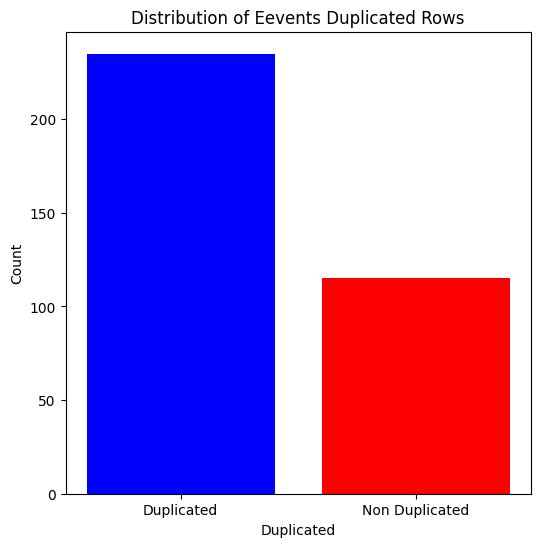

In [405]:
# Find and count duplicated rows
dupli_count = data_events.duplicated().value_counts()

# Create a count plot to visualize the distribution of duplicated rows
plt.figure(figsize=(6, 6))
plt.bar(['Duplicated', 'Non Duplicated'], dupli_count, color=['blue', 'red'])
plt.title('Distribution of Eevents Duplicated Rows')
plt.xlabel('Duplicated')
plt.ylabel('Count')
plt.show()

We have 235 duplicated holidays. Lets resample to check if they have same description